In [45]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [29]:
train = pd.read_csv("data/train_clean.csv", index_col="id", parse_dates=["timestamp"])
test = pd.read_csv("data/test_clean.csv", index_col="id", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [30]:
## add label
train["label_value"] = 0
train.loc[train["price_doc"] == 1000000, "label_value"] = 1
train.loc[train["price_doc"] == 2000000, "label_value"] = 2

In [31]:
y_train = train["label_value"]
x_train = train.drop(["timestamp", "price_doc", "label_value"], axis=1)

# transform non-numerical variables
for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [32]:
x_test = test.drop(["timestamp"], axis=1)

# transform non-numerical variables
for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        
x_test = x_test.astype(np.float32)

In [33]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "multi:softmax",
    "eval_metric": "mlogloss",
    "silent": 1,
    "num_class": 3,
    "seed":42
}

In [34]:
dtrain = xgb.DMatrix(x_train, y_train)

In [35]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-mlogloss:1.03578	test-mlogloss:1.03594
[50]	train-mlogloss:0.238168	test-mlogloss:0.249048
[100]	train-mlogloss:0.186419	test-mlogloss:0.218389


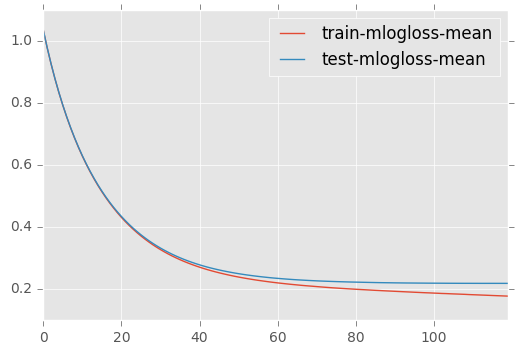

In [36]:
cv_output[["train-mlogloss-mean", "test-mlogloss-mean"]].plot()
pass

In [37]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

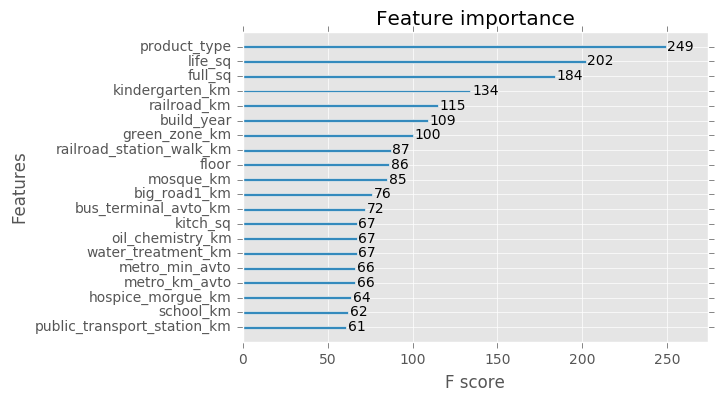

In [38]:
xgb.plot_importance(model, max_num_features=20)

In [41]:
pred = model.predict(dtrain)

In [44]:
pred = model.predict(dtrain)
accuracy_score(y_train, pred)

0.94869029811806449

In [46]:
confusion_matrix(y_train, pred)

array([[27252,     0,     1],
       [  742,     1,     0],
       [  732,     0,    19]])

### Prediction

In [47]:
dtest = xgb.DMatrix(x_test)

In [48]:
y_predict = model.predict(dtest)

In [51]:
output = pd.DataFrame({"id": x_test.index, "label_value": y_predict})